Loaded: breanna-data/trial6/cyton8_alternating-vep_32-class_1.2s/sub-01/ses-01/eeg-trials_2-per-class_run-1.npy with shape (30, 8, 350)
Loaded: breanna-data/trial1/cyton8_alternating-vep_32-class_1.2s/sub-01/ses-01/eeg-trials_2-per-class_run-1.npy with shape (30, 8, 350)
Loaded: breanna-data/trial4/cyton8_alternating-vep_32-class_1.2s/sub-01/ses-01/eeg-trials_2-per-class_run-1.npy with shape (30, 8, 350)
Loaded: breanna-data/trial3/cyton8_alternating-vep_32-class_1.2s/sub-01/ses-01/eeg-trials_2-per-class_run-1.npy with shape (30, 8, 350)
Loaded: breanna-data/trial2/cyton8_alternating-vep_32-class_1.2s/sub-01/ses-01/eeg-trials_2-per-class_run-1.npy with shape (30, 8, 350)
Loaded: breanna-data/trial5/cyton8_alternating-vep_32-class_1.2s/sub-01/ses-01/eeg-trials_2-per-class_run-1.npy with shape (30, 8, 350)
Final EEG Data Shape: (180, 8, 350) (Total Epochs, Channels, Timepoints)


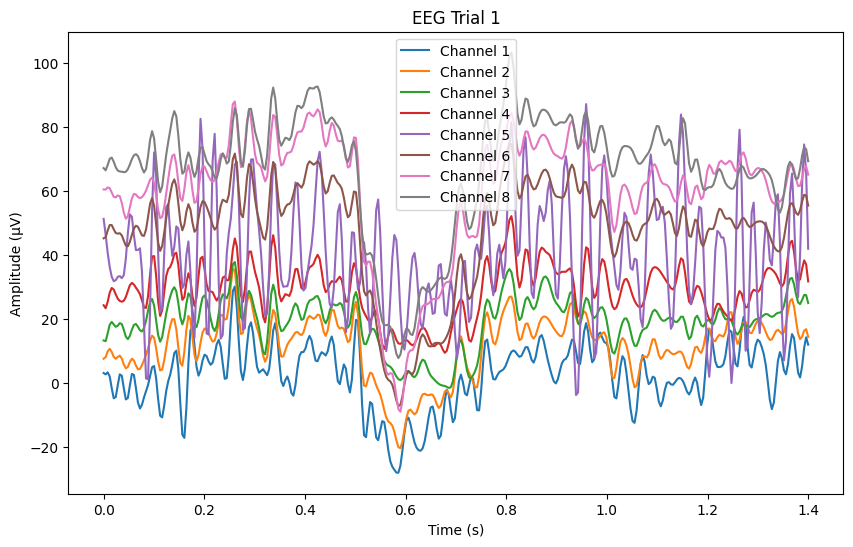

In [94]:
import numpy as np
import os
import matplotlib.pyplot as plt

#Step 1 Loading the Data

# Function to recursively find all .npy files as they are within multiple directories
def find_npy_files(directory):
    npy_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".npy"):
                npy_files.append(os.path.join(root, file))
    return npy_files

# Function to load only EEG trials and structure them
def load_eeg_trials(base_directory):
    npy_files = find_npy_files(base_directory)
    all_trials = []
    
    for file_path in npy_files:
        raw_data = np.load(file_path, allow_pickle=True)
        
        # Only load files that have the correct segmented EEG trial shape (30, 8, 350)
        if raw_data.ndim == 3 and raw_data.shape[1] == 8 and raw_data.shape[2] == 350:
            print(f"Loaded: {file_path} with shape {raw_data.shape}")
            all_trials.append(raw_data)
    
    if not all_trials:
        print("No valid segmented EEG trials found!")
        return None

    # Stack trials together: (total_epochs, 8, 350)
    eeg_data = np.vstack(all_trials)  
    print(f"Final EEG Data Shape: {eeg_data.shape} (Total Epochs, Channels, Timepoints)")

    return eeg_data

# Set the base directory
directory_path = "breanna-data"
eeg_data = load_eeg_trials(directory_path)

# Plot the first trial to check correctness
def plot_eeg_trial(data, trial_index=0):
    if data is None:
        print("No data to plot!")
        return

    num_channels, num_samples = data.shape[1], data.shape[2]
    time_axis = np.linspace(0, num_samples / 250, num_samples)  

    plt.figure(figsize=(10, 6))
    for ch in range(num_channels):
        plt.plot(time_axis, data[trial_index, ch, :] + ch * 10, label=f"Channel {ch+1}")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"EEG Trial {trial_index+1}")
    plt.legend()
    plt.show()

# Verify first trial
plot_eeg_trial(eeg_data)



Applying bandpass filter: 7-30 Hz...
Filtered EEG Data Shape (7-30 Hz): (180, 8, 350)

Applying bandpass filter: 7-13 Hz...
Filtered EEG Data Shape (7-13 Hz): (180, 8, 350)


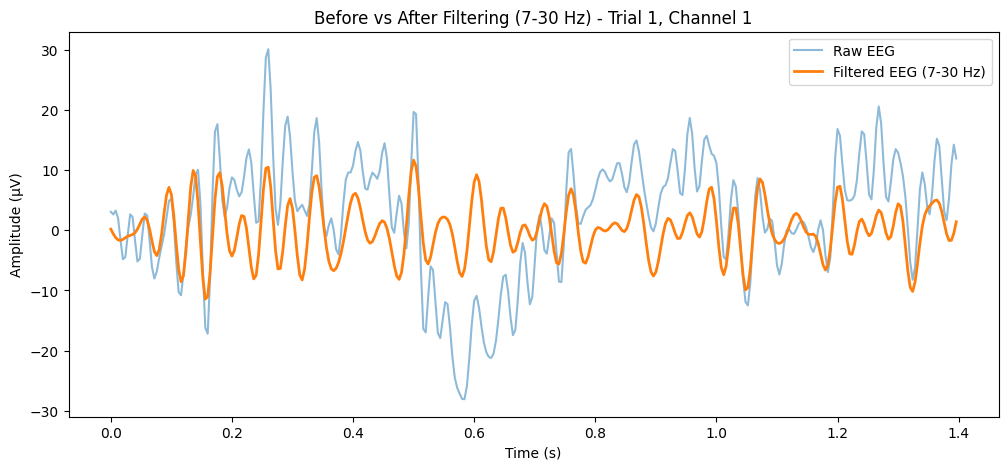

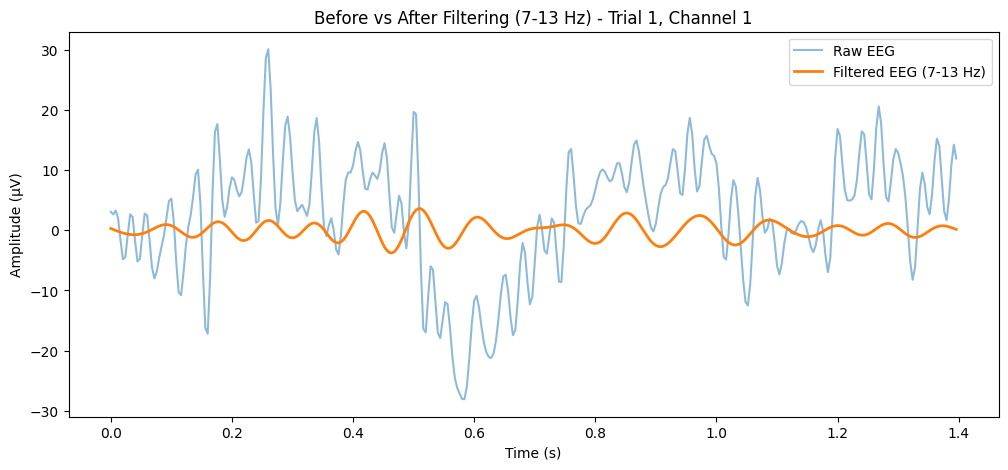

In [95]:
import numpy as np
import scipy.signal as signal

# Step 2: Bandpass Filtering
FS = 250  
ORDER = 5  

def bandpass_filter(data, lowcut, highcut, fs=FS, order=ORDER):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    return signal.sosfiltfilt(sos, data)

# Apply filtering to all epochs and channels efficiently
def apply_filter(eeg_data, lowcut, highcut):
    if eeg_data is None or eeg_data.size == 0:
        print("No valid EEG data to filter!")
        return None

    return np.apply_along_axis(bandpass_filter, axis=2, arr=eeg_data, lowcut=lowcut, highcut=highcut)

# Define frequency bands to test
freq_bands = {
    "7-30 Hz": (7, 30),
    "7-13 Hz": (7, 13)
}

# Store filtered EEG data for both frequency bands
filtered_eeg = {}

for band_name, (lowcut, highcut) in freq_bands.items():
    print(f"\nApplying bandpass filter: {band_name}...")
    filtered_eeg[band_name] = apply_filter(eeg_data, lowcut, highcut)

    if filtered_eeg[band_name] is not None:
        print(f"Filtered EEG Data Shape ({band_name}): {filtered_eeg[band_name].shape}")
    else:
        print(f"Filtering failed for {band_name}")

# Function to plot before vs. after filtering
def plot_filtered_eeg(original, filtered, band_name, trial_idx=0, channel_idx=0):
    if original is None or filtered is None:
        print(f"Cannot plot {band_name}: Data missing!")
        return
    
    if trial_idx >= original.shape[0] or channel_idx >= original.shape[1]:
        print(f"Invalid trial/channel index for {band_name}.")
        return

    time_axis = np.arange(original.shape[2]) / FS  
    
    plt.figure(figsize=(12, 5))
    plt.plot(time_axis, original[trial_idx, channel_idx, :], label="Raw EEG", alpha=0.5)
    plt.plot(time_axis, filtered[trial_idx, channel_idx, :], label=f"Filtered EEG ({band_name})", linewidth=2)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"Before vs After Filtering ({band_name}) - Trial {trial_idx + 1}, Channel {channel_idx + 1}")
    plt.legend()
    plt.show()

# Plot for both filter ranges (Trial 1, Channel 1)
for band_name in freq_bands.keys():
    plot_filtered_eeg(eeg_data, filtered_eeg[band_name], band_name, trial_idx=0, channel_idx=0)


Computing rank from data with rank=None
    Using tolerance 4.5 (2.2e-16 eps * 8 dim * 2.6e+15  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance u

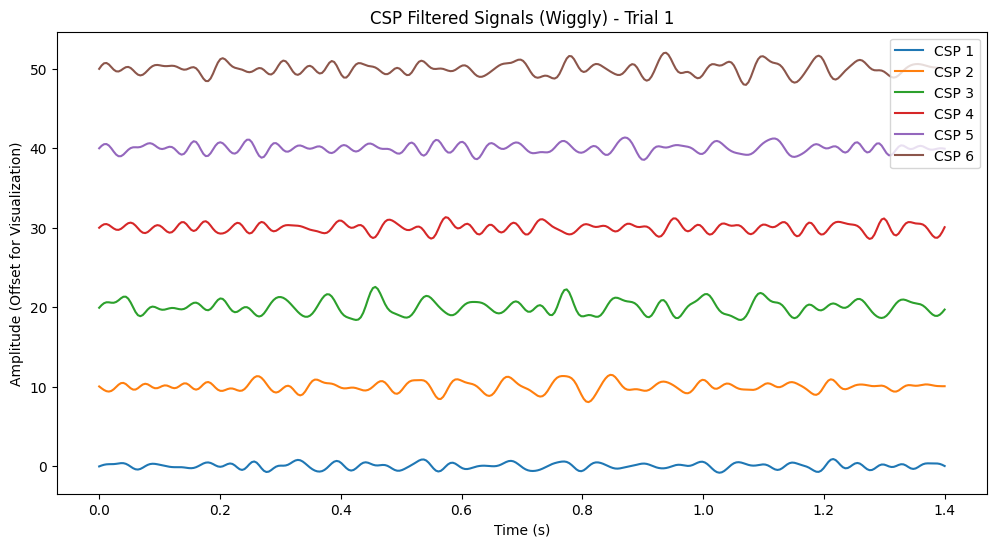

In [96]:
from mne.decoding import CSP
from sklearn.model_selection import train_test_split

# Step 3: Apply CSP transformation

# Select the 7-30 Hz filtered data
eeg_filtered = filtered_eeg["7-30 Hz"] 

# Extract 6 CSP-filtered signals
N_CSP_COMPONENTS = 6  

# Define labels
y = np.array([0] * (eeg_filtered.shape[0] // 2) + [1] * (eeg_filtered.shape[0] // 2))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(eeg_filtered, y, test_size=0.2, stratify=y, random_state=42)

# Apply CSP transformation
csp = CSP(n_components=N_CSP_COMPONENTS, log=False, cov_est='epoch')
csp.fit(X_train, y_train)  

# Manually apply CSP filters to EEG signals to get six filtered signals per trial
X_train_csp_signals = np.array([np.dot(csp.filters_, trial) for trial in X_train]) 
X_test_csp_signals = np.array([np.dot(csp.filters_, trial) for trial in X_test]) 

# Function to plot the six CSP-filtered signals for a trial
def plot_csp_signals(csp_filtered_data, trial_idx=0):
    time_axis = np.linspace(0, eeg_filtered.shape[2] / 250, eeg_filtered.shape[2])  # Convert samples to seconds

    plt.figure(figsize=(12, 6))
    for i in range(N_CSP_COMPONENTS):
        plt.plot(time_axis, csp_filtered_data[trial_idx, i, :] + i * 10, label=f"CSP {i+1}")  # Offset for visibility
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (Offset for Visualization)")
    plt.title(f"CSP Filtered Signals (Wiggly) - Trial {trial_idx + 1}")
    plt.legend()
    plt.show()


plot_csp_signals(X_train_csp_signals)

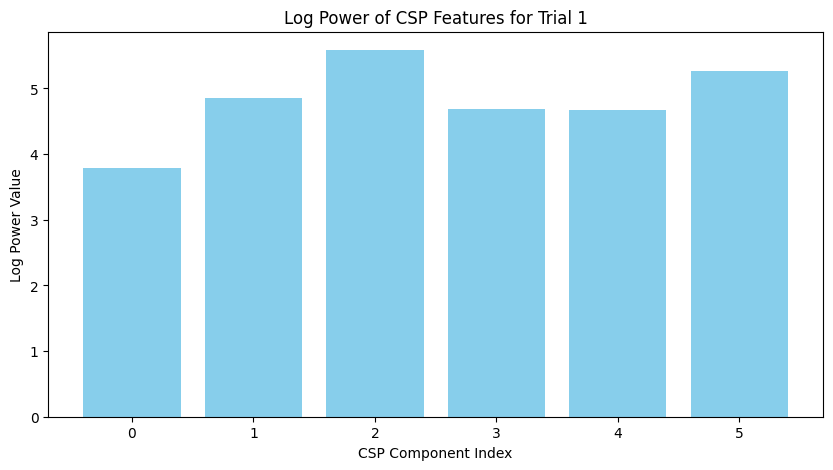

In [97]:
# Step 3 Continued

# Enforce 6 CSP Components
N_CSP_COMPONENTS = 6

# Ensure CSP-filtered signals use only the first 6 components
X_train_csp_signals = X_train_csp_signals[:, :N_CSP_COMPONENTS, :]
X_test_csp_signals = X_test_csp_signals[:, :N_CSP_COMPONENTS, :]

# Compute power of each CSP-filtered signal (sum of squares over time)
X_train_power = np.sum(X_train_csp_signals ** 2, axis=2)
X_test_power = np.sum(X_test_csp_signals ** 2, axis=2)

# Take the log of power values
X_train_log_power = np.log(X_train_power)
X_test_log_power = np.log(X_test_power)

# Plot Log Power Features
def plot_log_power_features(log_power_data, trial_idx=0):
    plt.figure(figsize=(10, 5))
    plt.bar(range(N_CSP_COMPONENTS), log_power_data[trial_idx, :], color='skyblue')
    plt.xlabel("CSP Component Index")
    plt.ylabel("Log Power Value")
    plt.title(f"Log Power of CSP Features for Trial {trial_idx + 1}")
    plt.show()

plot_log_power_features(X_train_log_power)


Processing Frequency Band: 7-13 Hz
Computing rank from data with rank=None
    Using tolerance 2.4 (2.2e-16 eps * 8 dim * 1.4e+15  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
D

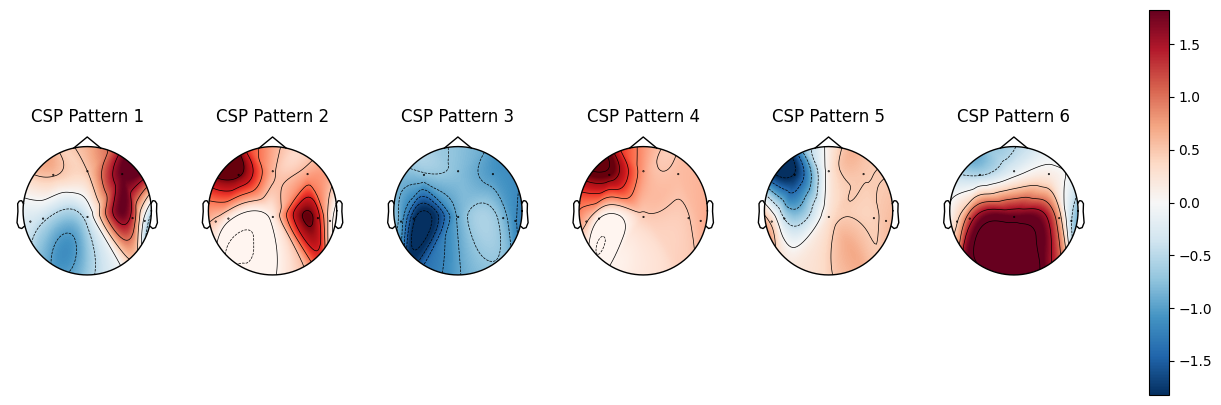

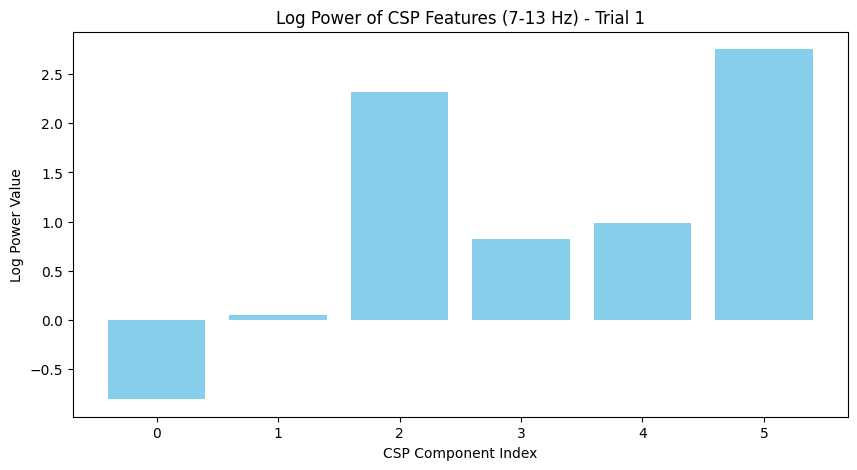

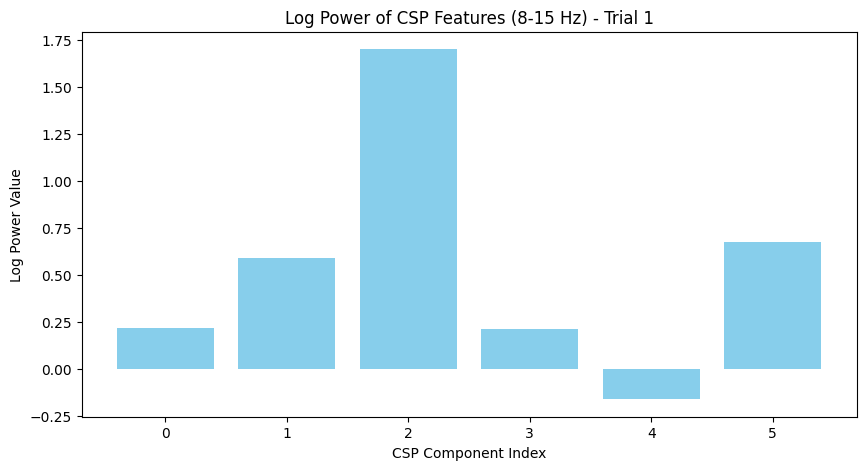

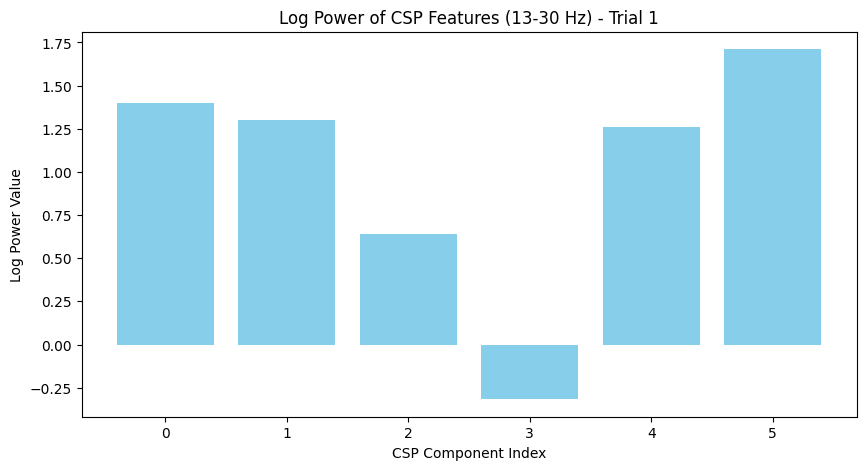

In [98]:
import mne
from mne.decoding import CSP
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split

# Step 4: Filter Bank Common Spatial Pattern (FBCSP)

FREQ_BANDS = {
    "7-13 Hz": (7, 13),
    "8-15 Hz": (8, 15),
    "13-30 Hz": (13, 30)
}

FS = 250  
N_CSP_COMPONENTS = 6  

# Bandpass Filter Function
def bandpass_filter(data, lowcut, highcut, fs=FS, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Ensure eeg_filtered is available (load or define it before running this script)
assert 'eeg_filtered' in locals(), "Error: eeg_filtered data is missing!"
assert 'y' in locals(), "Error: y labels are missing!"

# Store FBCSP features
filtered_csp_features = {}

for band_name, (low, high) in FREQ_BANDS.items():
    print(f"\nProcessing Frequency Band: {band_name}")

    # Apply bandpass filtering
    filtered_data = np.zeros_like(eeg_filtered)
    for trial in range(eeg_filtered.shape[0]):
        for ch in range(eeg_filtered.shape[1]):
            filtered_data[trial, ch, :] = bandpass_filter(eeg_filtered[trial, ch, :], low, high)

    X_train, X_test, y_train, y_test = train_test_split(filtered_data, y, test_size=0.2, stratify=y, random_state=42)

    csp = CSP(n_components=N_CSP_COMPONENTS, log=False, cov_est='epoch')
    X_train_csp = csp.fit_transform(X_train, y_train)
    X_test_csp = csp.transform(X_test)

    X_train_power = np.sum(X_train_csp ** 2, axis=1)
    X_test_power = np.sum(X_test_csp ** 2, axis=1)

    X_train_log_power = np.log(X_train_power).reshape(-1, N_CSP_COMPONENTS)  
    X_test_log_power = np.log(X_test_power).reshape(-1, N_CSP_COMPONENTS)  

    filtered_csp_features[band_name] = {
        "train_csp": X_train_csp,
        "test_csp": X_test_csp,
        "train_log_power": X_train_log_power,
        "test_log_power": X_test_log_power,
        "csp_patterns": csp.patterns_
    }

# Function to Plot CSP Patterns
def plot_csp_patterns(csp, ch_names):
    montage = mne.channels.make_standard_montage("standard_1020")

    # Extract valid positions (some channels may be missing)
    pos = []
    valid_ch_names = []
    for ch in ch_names:
        if ch in montage.ch_names:
            pos.append(montage.get_positions()['ch_pos'][ch][:2])  # Take (x, y)
            valid_ch_names.append(ch)

    if not pos:
        raise ValueError("Error: No valid channels found in montage.")

    pos = np.array(pos)

    # Plot CSP Patterns
    fig, axes = plt.subplots(1, N_CSP_COMPONENTS, figsize=(15, 5))

    for i, ax in enumerate(axes):
        im, _ = mne.viz.plot_topomap(csp.patterns_[i], pos, axes=ax, show=False)
        ax.set_title(f"CSP Pattern {i+1}")

   
    plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
    plt.show()

# Update channel names to match your setup
channel_names = ['C3', 'Cz', 'C4', 'Fz', 'F3', 'F4', 'T3', 'T4']

# Run CSP Pattern Plotting
plot_csp_patterns(csp, channel_names)

# Function to Plot Log Power Features for Each Band
def plot_log_power_features(log_power_data, band_name, trial_idx=0):
    plt.figure(figsize=(10, 5))
    plt.bar(range(N_CSP_COMPONENTS), log_power_data[trial_idx], color='skyblue')
    plt.xlabel("CSP Component Index")
    plt.ylabel("Log Power Value")
    plt.title(f"Log Power of CSP Features ({band_name}) - Trial {trial_idx + 1}")
    plt.show()

# Visualize log power for a sample trial across all bands
for band_name, data in filtered_csp_features.items():
    plot_log_power_features(data["train_log_power"], band_name)


In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Step 5 LDA and SVM Classifiers 
y_train, y_test = train_test_split(y, test_size=0.2, stratify=y, random_state=42)
y_train = y_train[:X_train_log_power.shape[0]]

clf = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto', n_components = min(N_CSP_COMPONENTS, len(np.unique(y_train)) - 1))
clf.fit(X_train_log_power, y_train)

# 5-fold cross validation
nfolds = 5
score = cross_val_score(clf, X_train_log_power, y_train, cv=nfolds)

# Print out the mean score
print(f'Mean classifier accuracy: {np.mean(score)}')

Mean classifier accuracy: 0.63


In [103]:
# Step 6 Pairwise classification 
def csp_accuracy(data):

    N_CSP_COMPONENTS = 6  

    y = np.array([0] * (len(data) // 2) + [1] * (len(data) // 2))

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y, random_state=42)

    # Ensure no data leakage
    print("Overlap between train and test sets:", np.intersect1d(X_train, X_test).size)

    csp = CSP(n_components=6, log=False, cov_est='epoch')
    csp.fit(X_train, y_train)

    X_train_csp_signals = np.array([np.dot(csp.filters_, trial) for trial in X_train]) 
    X_test_csp_signals = np.array([np.dot(csp.filters_, trial) for trial in X_test]) 

    X_train_csp_signals = X_train_csp_signals[:, :N_CSP_COMPONENTS, :]
    X_test_csp_signals = X_test_csp_signals[:, :N_CSP_COMPONENTS, :]

    X_train_power = np.sum(X_train_csp_signals ** 2, axis=2)
    X_test_power = np.sum(X_test_csp_signals ** 2, axis=2)

    X_train_log_power = np.log(X_train_power)
    X_test_log_power = np.log(X_test_power)

    #Ensure 2D shape
    X_train_log_power = np.log(X_train_power).reshape(-1, N_CSP_COMPONENTS)  
    X_test_log_power = np.log(X_test_power).reshape(-1, N_CSP_COMPONENTS)  

    #Ensure y_train is the correct shape
    y_train = y_train[:X_train_log_power.shape[0]]

    clf = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto', n_components = min(N_CSP_COMPONENTS, len(np.unique(y_train)) - 1))
    clf.fit(X_train_log_power, y_train)

    # 4-fold cross validation
    nfolds = 4
    score = cross_val_score(clf, X_train_log_power, y_train, cv=nfolds) 

    # Compute mean score
    accuracy_mean = np.mean(score)

    # Make predictions 
    conf = clf.decision_function(X_test_log_power) 
    pred = clf.predict(X_test_log_power)

    # Dictionary to return accuracy, confidence interval, and predicted labels 
    accuracy_test = {
        "accuracy": accuracy_mean,
        "csp": csp,
        "confidence": conf,
        "predicted": pred
    }
    return accuracy_test

In [104]:
# Make function to later plot accuracies
def plot_accuracies(accuracies, frequencies): 
    index = np.arange(len(accuracies))
    plt.figure(figsize=(10, 5))
    for i in range(len(accuracies)):
        plt.bar(index[i], accuracies[i], color='skyblue')
    plt.xlabel("Pair index")
    plt.ylabel("Accuracy")
    plt.title(f"Paired Classification Accuracies ({frequencies})")
    plt.show()

# Function to create paired array's
def paired_trials(data):
    word_order = ['Jump', 'Raise right arm', 'Left kick', 'Raise left arm', 'Raise left arm', 
              'Left kick', 'Right kick', 'Clap', 'Raise left arm', 'Clap', 'Clap', 'Right kick', 
              'Jump', 'Clap', 'Right kick', 'Raise right arm', 'Raise left arm', 'Left kick', 
              'Raise left arm', 'Raise right arm', 'Jump', 'Raise right arm', 'Jump', 
              'Raise right arm', 'Clap', 'Right kick', 'Right kick', 'Left kick', 'Left kick',
              'Jump']
    
    word_to_trials = {word: [] for word in set(word_order)}
    for trial, word in enumerate(word_order):
        word_to_trials[word].append(data[trial])

    # Ensure trials for pairs will be balanced
    min_trials = min(len(word_to_trials[word]) for word in word_to_trials)
    balanced_word_to_trials = {word: word_to_trials[word][:min_trials] for word in word_to_trials}
    
    pairs = []
    pairs.append(np.concatenate((balanced_word_to_trials['Jump'], balanced_word_to_trials['Raise right arm'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Jump'], balanced_word_to_trials['Right kick'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Jump'], balanced_word_to_trials['Clap'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Jump'], balanced_word_to_trials['Raise left arm'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Jump'], balanced_word_to_trials['Left kick'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Right kick'], balanced_word_to_trials['Raise right arm'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Right kick'], balanced_word_to_trials['Clap'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Right kick'], balanced_word_to_trials['Raise left arm'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Right kick'], balanced_word_to_trials['Left kick'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Raise right arm'], balanced_word_to_trials['Clap'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Raise right arm'], balanced_word_to_trials['Raise left arm'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Raise right arm'], balanced_word_to_trials['Left kick'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Clap'], balanced_word_to_trials['Raise left arm'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Clap'], balanced_word_to_trials['Left kick'])))
    pairs.append(np.concatenate((balanced_word_to_trials['Raise left arm'], balanced_word_to_trials['Left kick'])))

    # Randomize trials for each pair
    i = 0
    for i in range(len(pairs)):
        np.random.shuffle(pairs[i])

    return pairs

In [105]:
# Get pairs for 7-30 Hz
pairs7_30 = paired_trials(eeg_filtered)

# Run CSP and 4-fold Cross-val on paired arrays
gen_accuracies = []
gen_csps = []
for pair in pairs7_30:
    accuracy_test = csp_accuracy(pair)
    gen_accuracies.append(accuracy_test["accuracy"])
    gen_csps.append(accuracy_test["csp"])

# Repeat same process for other frequency bands 
data_eeg13 = filtered_eeg['7-13 Hz']

pairs7_13 = paired_trials(data_eeg13)

accuracies7_13 = []
csps7_13 = []
for pair in pairs7_13:
    accuracy_test = csp_accuracy(pair)
    accuracies7_13.append(accuracy_test["accuracy"])
    csps7_13.append(accuracy_test["csp"])

Overlap between train and test sets: 0
Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 8 dim * 6.6e+14  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Overlap between train and test sets: 0
Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 8 dim * 7e+14  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covaria

Overlap between train and test sets: 0
Computing rank from data with rank=None
    Using tolerance 0.66 (2.2e-16 eps * 8 dim * 3.7e+14  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Overlap between train and test sets: 0
Computing rank from data with rank=None
    Using tolerance 0.68 (2.2e-16 eps * 8 dim * 3.8e+14  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 cov

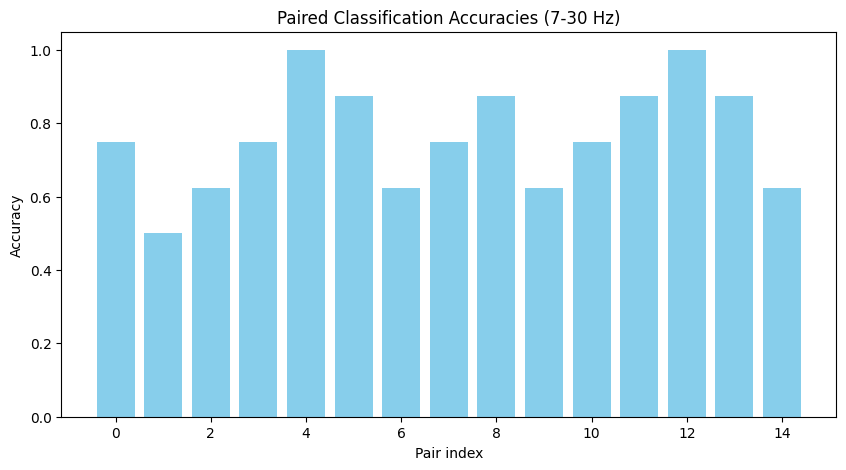

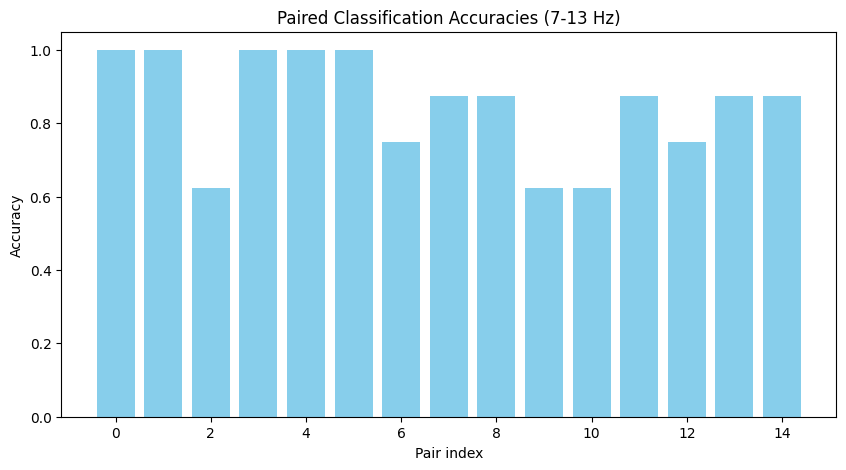

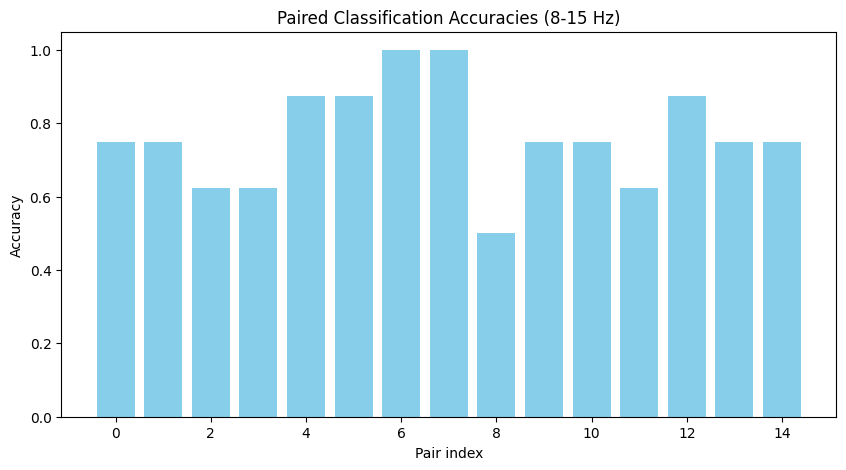

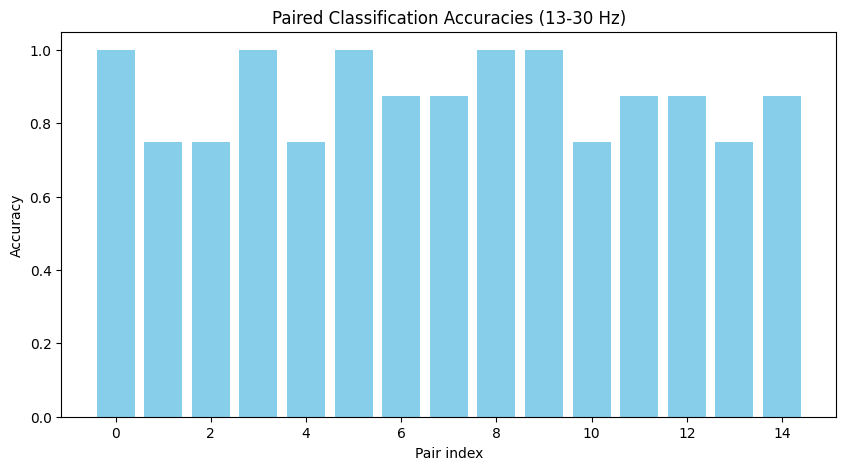

In [106]:
# Repeat process, continued
eeg_data15 = apply_filter(eeg_data, lowcut = 8, highcut = 15)

pairs8_15 = paired_trials(eeg_data15)

accuracies8_15 = []
csps8_15 = []
for pair in pairs8_15:
    accuracy_test = csp_accuracy(pair)
    accuracies8_15.append(accuracy_test["accuracy"])
    csps8_15.append(accuracy_test["csp"])


eeg_data30 = apply_filter(eeg_data, lowcut = 13, highcut = 30)

pairs13_30 = paired_trials(eeg_data30)

accuracies13_30 = []
csps13_30 = []
for pair in pairs13_30:
    accuracy_test = csp_accuracy(pair)
    accuracies13_30.append(accuracy_test["accuracy"])
    csps13_30.append(accuracy_test["csp"])

# Plot accuracies for all frequency bands
plot_accuracies(gen_accuracies, "7-30 Hz")
plot_accuracies(accuracies7_13, "7-13 Hz")
plot_accuracies(accuracies8_15, "8-15 Hz")
plot_accuracies(accuracies13_30, "13-30 Hz")

Most accurate pair index: 4
Highest Accuracy: 1.00
CSP patterns shape: (8, 8)


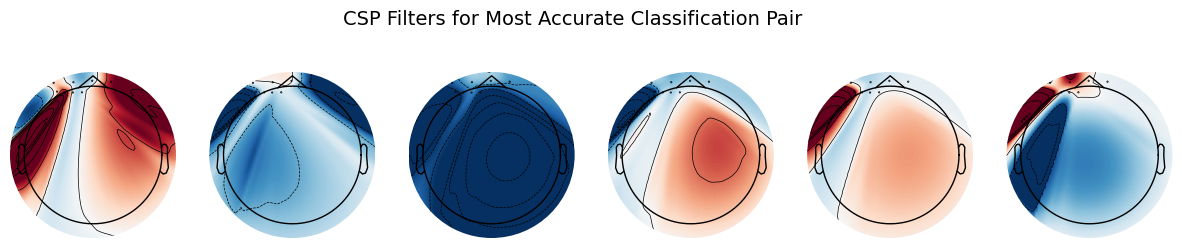

In [112]:
# Step 7 Visualize CSPs for most accurate paired classification

# Run CSP Pattern Plotting for highest accuracies 
best_pair_index = np.argmax(gen_accuracies)

print(f"Most accurate pair index: {best_pair_index}")
print(f"Highest Accuracy: {gen_accuracies[best_pair_index]:.2f}")

best_csp = gen_csps[best_pair_index]

csp_patterns = best_csp.patterns_

print(f"CSP patterns shape: {csp_patterns.shape}")

montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=montage.ch_names[:csp_patterns.shape[0]], sfreq=250, ch_types="eeg")
info.set_montage(montage)


fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    mne.viz.plot_topomap(csp_patterns[i], info, axes=axes[i], show=False)

plt.suptitle("CSP Filters for Most Accurate Classification Pair", fontsize=14)
plt.show()